In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# from plot_config import *

In [3]:
rerun = False
regen_talk = True

In [4]:
map_path = '/sciserver/filedb02-02/ocean/wenrui_temp/dic_exp/map1.zarr'
table_path = '/sciserver/filedb02-02/ocean/wenrui_temp/dic_exp/table1.zarr'
particle_path = '/sciserver/filedb02-02/ocean/wenrui_temp/dic_exp/'
pre = 'precalc/dic_'

In [5]:
if rerun:
    # maps = xr.open_zarr(map_path)
    tb = xr.open_zarr(table_path)
    tb['total_bio'] = tb['cdicpflx']+tb['cdicrdop']+tb['cnegbio']
    indf = list(np.array(tb[var][-1].chunk((9973))).astype(int) for var in ['iz','iy','ix'])
    indf[0]-=1
    indf = tuple(indf)
    ds = xr.open_zarr('/sciserver/filedb02-02/ocean/wenrui_temp/dic_exp/bgc_tutorial.zarr')
    sf = np.array(ds.S[-1])[indf]
    tf = np.array(ds.Temp[-1])[indf]
    t0 = 0.5
    t1 = 4
    s0 = 34.4
    ind_bw = np.where(tf<=t0)[0]
    ind_dw = np.where(np.logical_and(np.logical_and(tf>t0,sf>s0),tf<=t1))[0]
    ind_iw = np.where(np.logical_and(tf>t0,sf<=s0))[0]
    ind_lw = np.where(np.logical_and(np.logical_and(tf>t0,sf>s0),tf>t1))[0]
    print(
        len(ind_bw),
        len(ind_dw),
        len(ind_iw),
        len(ind_lw),
    )
    bw = tb.isel(space = ind_bw)
    dw = tb.isel(space = ind_dw)
    iw = tb.isel(space = ind_iw)
    lw = tb.isel(space = ind_lw)
    for name in ['bw','dw','iw','lw','tb']:
        print()
        print(name)
        table = eval(name)
        pre = 'precalc/dic_'

        state_var = ['pf','pl','cf','cl']
        cum_var = [i for i in table.data_vars if i not in state_var]
        
        cum = table[cum_var].cumsum(dim = 'time')
        
        size = len(cum.time)
        
        mean = cum.mean(dim = 'space')
        std = cum.std(dim = 'space')
        
        for var in table.data_vars:
            print(var,end = ' ')
            if var in state_var:
                mean[var] = table[var].mean(dim = 'space').chunk(size)
            else:
                mean[var] = mean[var].chunk(size)
            
        mean.to_zarr(pre+name+'mean',mode = 'w')
        
        for var in table.data_vars:
            print(var,end = ' ')
            if var in state_var:
                std[var] = table[var].std(dim = 'space').chunk(size)
            else:
                std[var] = std[var].chunk(size)
        
        std.to_zarr(pre+name+'std',mode = 'w')

In [6]:
term_longname = {
    'c_dif_h':'Horizontal diffusion',
    'c_dif_v':'Vertical diffusion',
    'total_bio':'Total biological activity',
    'cerror':'Surface correction',
    'cf':'DIC concentration',
    'cl':'DIC concentration',
    'diccarb': 'Calcium carbonate cycle',
    'dicpflx': 'Accumulation of remineralized phosphorus',
    'dicrdop': 'Remineralization of dissolved organic phosphorus',
    'dictflx': 'DIC exchange with the atmosphere',
    'e_ua_c':'Unresolved advection',
    'e_ua_p':'Unresolved advection',
    'forc_c':'Dilution',
    'forc_p':'Dilution',
    'negbio':'Net community uptake of phosphorus',
    'p_dif_h':'Horizontal diffusion',
    'p_dif_v':'Vertical diffusion',
    'perror':'Surface correction',
    'pf':'Phosphate Concentration',
    'pl':'Phosphate Concentration',
}
list(set(term_longname.values()))

['Horizontal diffusion',
 'Net community uptake of phosphorus',
 'Total biological activity',
 'Phosphate Concentration',
 'Accumulation of remineralized phosphorus',
 'DIC concentration',
 'Calcium carbonate cycle',
 'Surface correction',
 'Unresolved advection',
 'Remineralization of dissolved organic phosphorus',
 'Dilution',
 'Vertical diffusion',
 'DIC exchange with the atmosphere']

# Let the plotting begin

In [7]:
xtime = (np.arange(3000)+0.5)/365.2422*5

In [8]:
extra_text = 'The spread are enhanced 10 times'

In [9]:
water2color = {
    'lw':'#FEC601',
    'iw':'#5B8C5A',
    'dw':'#EA7317',
    'bw':'#3D3B8E'
}

term2longname = {
    'c_dif_h':'Horizontal diffusion',
    'c_dif_v':'Vertical diffusion',
    'total_bio':'Total biological activity',
    'cerror':'Surface correction',
    'cf':'DIC concentration',
    'cl':'DIC concentration',
    'diccarb': 'Calcium carbonate cycle',
    'dicpflx': 'Remineralization of sediment',
    'dicrdop': 'Remineralization of DOP',
    'dictflx': 'Surface DIC flux',
    'e_ua_c':'Unresolved advection',
    'e_ua_p':'Unresolved advection',
    'forc_c':'Dilution',
    'forc_p':'Dilution',
    'negbio':'Community phosphorus uptake',
    'p_dif_h':'Horizontal diffusion',
    'p_dif_v':'Vertical diffusion',
    'perror':'Surface correction',
    'pf':'Phosphate Concentration',
    'pl':'Phosphate Concentration',
}

longname2color = {
    'Community phosphorus uptake':'#44CF6C',
    'Phosphate Concentration':'#B3001B',
    'Remineralization of sediment':'#8B6220',
    'Vertical diffusion':'#7D84B2',
    'Total biological activity':'#717744',
    'Remineralization of DOP':'#A5BE00',
    'Dilution':'#2EC4B6',
    'Surface correction':'#DB5461',
    'Calcium carbonate cycle':'#CCAD8F',
    'Unresolved advection':'#C75000',
    'Horizontal diffusion':'#427AA1',
    'Surface DIC flux':'#E7E247',
    'DIC concentration':'g',
}
term2color = {}
for term in term2longname.keys():
    term2color[term] = longname2color[term2longname[term]]

number = [1084,1898, 2864, 4350]
watername = ['AABW','CDW','AAIW','Low-latitude water']
water = ['bw','dw','iw','lw']
water2number = dict(zip(water,number))
water2longname = dict(zip(water,watername))

crhs_list = ['e_ua_c','c_dif_h','c_dif_v','diccarb','dictflx','forc_c','total_bio']
prhs_list = ['e_ua_p','p_dif_h','p_dif_v','dicrdop','dicpflx','forc_p','negbio']

e_ua_c
c_dif_h
c_dif_v
diccarb
dictflx
forc_c
total_bio


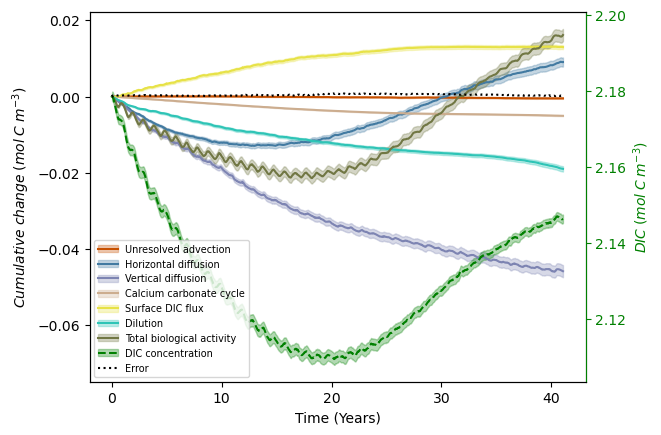

In [10]:
name = 'iw'
tracer = 'c'
if tracer == 'c':
    rhs_list = crhs_list
    ylabel = r'$DIC\;(mol\;C\;m^{-3})$'
    ylabel1 = r'$Cumulative\;change \;(mol\;C\;m^{-3})$'
else:
    rhs_list  =prhs_list
    ylabel = r'$Phospate\;(mol\;P\;m^{-3})$'
    ylabel1 = r'$Cumulative\;change \;(mol\;P\;m^{-3})$'
plt.clf()
mean = xr.open_zarr(pre+name+'mean')
std = xr.open_zarr(pre+name+'std')
ax = plt.axes()
handles = []
labels = []
NUMBER_OF_PARTICLE = water2number[name]
for var in rhs_list:
    print(var)
    a_mean = mean[var]
    a_std = std[var]/np.sqrt(NUMBER_OF_PARTICLE-1)
    mean_line, = ax.plot(xtime, a_mean, color=term2color[var])
    spread_area = ax.fill_between(xtime, a_mean - a_std, a_mean + a_std, alpha=0.3, color=term2color[var])
    handles.append((mean_line, spread_area))
    labels.append(term2longname[var])
trac = np.array(mean[tracer+'l'])
trac_std = np.array(std[tracer+'l'])/np.sqrt(NUMBER_OF_PARTICLE-1)
offset = float(mean[tracer+'f'][0])
tracer_line, = ax.plot(xtime, trac-offset,'--',color = term2color[tracer+'l'])
tracer_area  = ax.fill_between(xtime, trac-offset - trac_std, trac-offset + trac_std, alpha=0.3, color=term2color[tracer+'l'])
handles.append((tracer_line, tracer_area))
labels.append(term2longname[tracer+'l'])

error = trac-offset
for var in rhs_list:
    error -= np.array(mean[var])
error_line, = ax.plot(xtime,error,'k:')
handles.append(error_line)
labels.append('Error')

plt.xlabel('Time (Years)')
ax.set_ylabel(ylabel1)

ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim()[0] + offset, ax.get_ylim()[1] + offset)
ax2.spines['right'].set_edgecolor(color=term2color[tracer+'l'])
ax2.yaxis.label.set_color(term2color[tracer+'l'])
ax2.tick_params(axis = 'y',colors=term2color[tracer+'l'])
ax2.set_ylabel(ylabel)

legend = ax.legend(handles,labels,fontsize = 7,loc = 0)

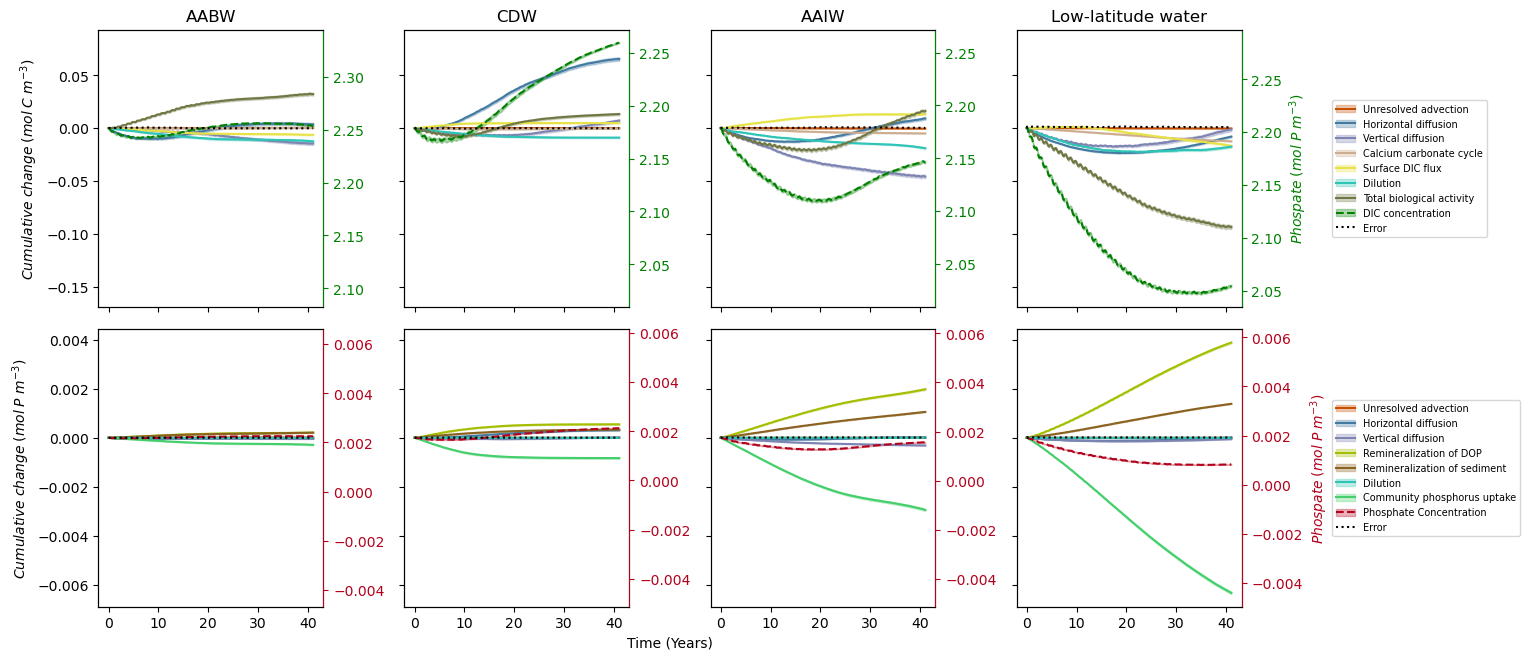

In [11]:
fig,axs = plt.subplots(2,4,figsize = (16,7),sharey = 'row', sharex = True)
axs = axs.ravel()
comb = []
offsets = []
for tracer in ['c','p']:
    for name in water:
        comb.append((name,tracer))
for i,ax in enumerate(axs):
    name, tracer = comb[i]
    if tracer == 'c':
        rhs_list = crhs_list
        ylabel = r'$DIC\;(mol\;C\;m^{-3})$'
        ylabel1 = r'$Cumulative\;change \;(mol\;C\;m^{-3})$'
    else:
        rhs_list  =prhs_list
        ylabel = r'$Phospate\;(mol\;P\;m^{-3})$'
        ylabel1 = r'$Cumulative\;change \;(mol\;P\;m^{-3})$'
    mean = xr.open_zarr(pre+name+'mean')
    std = xr.open_zarr(pre+name+'std')
    # ax = plt.axes()
    handles = []
    labels = []
    NUMBER_OF_PARTICLE = water2number[name]
    for var in rhs_list:
        a_mean = mean[var]
        a_std = std[var]/np.sqrt(NUMBER_OF_PARTICLE-1)
        mean_line, = ax.plot(xtime, a_mean, color=term2color[var])
        spread_area = ax.fill_between(xtime, a_mean - a_std, a_mean + a_std, alpha=0.3, color=term2color[var])
        handles.append((mean_line, spread_area))
        labels.append(term2longname[var])
    trac = np.array(mean[tracer+'l'])
    trac_std = np.array(std[tracer+'l'])/np.sqrt(NUMBER_OF_PARTICLE-1)
    offset = float(mean[tracer+'f'][0])
    tracer_line, = ax.plot(xtime, trac-offset,'--',color = term2color[tracer+'l'])
    tracer_area  = ax.fill_between(xtime, trac-offset - trac_std, trac-offset + trac_std, alpha=0.3, color=term2color[tracer+'l'])
    handles.append((tracer_line, tracer_area))
    labels.append(term2longname[tracer+'l'])
    
    error = trac-offset
    for var in rhs_list:
        error -= np.array(mean[var])
    error_line, = ax.plot(xtime,error,'k:')
    handles.append(error_line)
    labels.append('Error')
    if i in range(4):
        ax.set_title(water2longname[name])
    if i in [0,4]:
        ax.set_ylabel(ylabel1)
    if i in [3,7]:
        legend = ax.legend(handles,labels,fontsize = 7,loc = 'center left',bbox_to_anchor=(1.38, 0.5))
    offsets.append(offset)
for i,ax in enumerate(axs):
    if i<4:
        tracer = 'c'
    else:
        tracer = 'p'
    offset = offsets[i]
    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim()[0] + offset, ax.get_ylim()[1] + offset)
    ax2.spines['right'].set_edgecolor(color=term2color[tracer+'l'])
    ax2.yaxis.label.set_color(term2color[tracer+'l'])
    ax2.tick_params(axis = 'y',colors=term2color[tracer+'l'])
    if i in [3,7]:
        ax2.set_ylabel(ylabel)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Time (Years)')
plt.tight_layout()
plt.savefig('figure2.tiff')
plt.show()

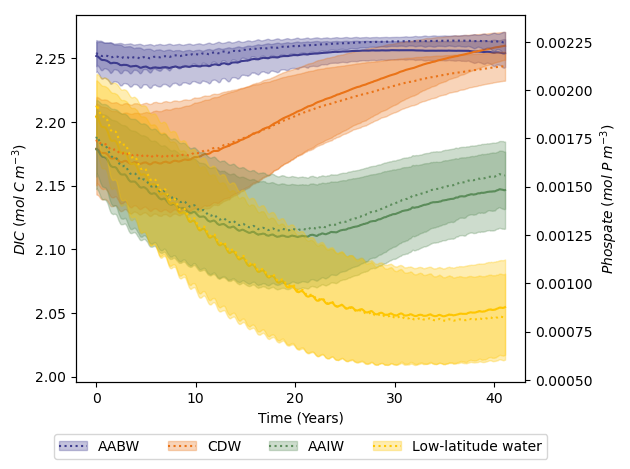

In [12]:
# fig,axs = plt.subplots(1,2,figsize = (16,9))
fig = plt.figure()
ax = plt.axes()
twinx = plt.twinx(ax)
axs = [ax,twinx]
for i,tracer in enumerate(['c','p']):
    ax = axs[i]
    handles = []
    labels = []
    for name in water:
        if tracer == 'c':
            rhs_list = crhs_list
            ylabel = r'$DIC\;(mol\;C\;m^{-3})$'
            linestyle = '-'
            # ylabel1 = r'$Cumulative\;change \;(mol\;C\;m^{-3})$'
        else:
            rhs_list  =prhs_list
            ylabel = r'$Phospate\;(mol\;P\;m^{-3})$'
            linestyle = ':'
            # ylabel1 = r'$Cumulative\;change \;(mol\;P\;m^{-3})$'
        mean = xr.open_zarr(pre+name+'mean')
        std = xr.open_zarr(pre+name+'std')

        trac = np.array(mean[tracer+'l'])
        trac_std = np.array(std[tracer+'l'])/2
        tracer_line, = ax.plot(xtime, trac,linestyle,color = water2color[name])
        tracer_area  = ax.fill_between(xtime, trac - trac_std, trac + trac_std, alpha=0.3, color=water2color[name])
        handles.append((tracer_line, tracer_area))
        labels.append(water2longname[name])
        ax.set_ylabel(ylabel)
        ax.set_xlabel('Time (Years)')
ax_all=fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
ax_all.legend(handles,labels,fontsize = 10,loc = 'lower center',bbox_to_anchor=(0.5, -0.23),ncol = 4)
plt.tight_layout()
plt.savefig(
    'fig1(d).tiff'
)